In [2]:
# import pickle
import numpy as np
from scipy.spatial import distance
from collections import defaultdict
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import normalized_mutual_info_score
from tqdm.auto import tqdm, trange
from sklearn.metrics.pairwise import euclidean_distances

from src.colorconv import ConvexCluster
from src.util import (compression,
                      informativeness,
                      non_dominated_front,
                      degree_of_convexity)
import statsmodels.api as sm

np.seterr(divide='ignore', invalid='ignore')

NOISE = 0
NUMBER = 5
SHAPE = (5, 5)

sns.set(context='paper', style='ticks', font='DejaVu Sans', font_scale=1)

In [3]:
coords = np.array(np.meshgrid(np.arange(SHAPE[0]), np.arange(SHAPE[1]))).T.reshape(-1, 2)
coords = [tuple(i) for i in coords]
# dictionary mapping coords to themselves
coords_dict = defaultdict(list)
for i, coord in enumerate(coords):
    coords_dict[tuple(coord)] = tuple(coord)

In [4]:
# reverse dictionary mapping coords to themselves
coords_dict_rev = {}
for i, coord in enumerate(coords):
    coords_dict_rev[tuple(coord)] = tuple(coord)

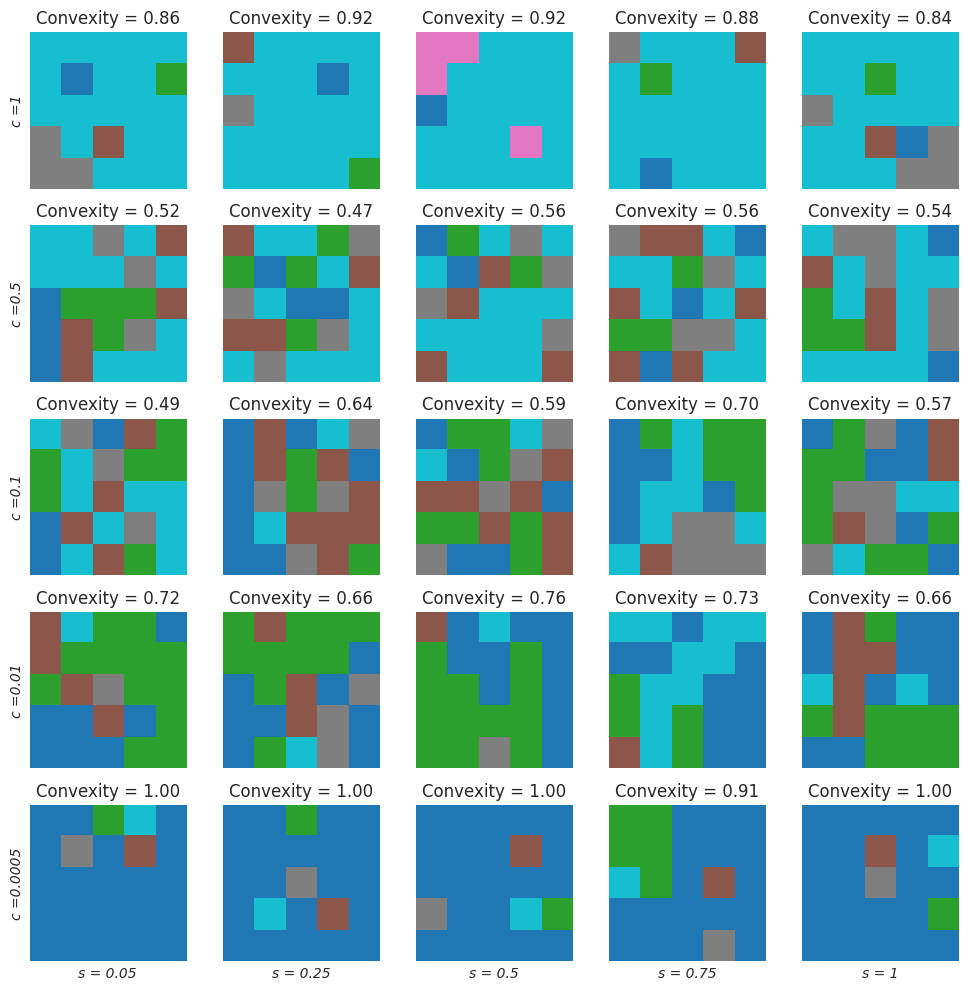

In [5]:
# plot 4 x 4 possible color clusters with parameter smooth in [0.1, 0.25, 0.5, 1] and conn in [0.1, 0.25, 0.5, 1]
fig, ax = plt.subplots(5, 5, figsize=(10, 10))

smooth_values = [0.05, 0.25, 0.5, 0.75, 1]
conn_values = [0.0005, 0.01, 0.1, 0.5, 1]
conn_values = [_ for _ in reversed(conn_values)]

for i, smooth in enumerate(smooth_values):
    for j, conn in enumerate(conn_values):
        a = ConvexCluster(X = np.zeros(SHAPE), 
                                d = 5, 
                                N = NUMBER, 
                                s = smooth, 
                                c = conn,
                                coords=coords,
                                reverse_labels=coords_dict)
        labels = a.run()
        ax[i, j].imshow(labels, 
                        cmap='tab10', 
                        interpolation='none')
        ax[i, j].set_xticks([])
        ax[i, j].set_yticks([])
        ax[i, j].set_title(f'Convexity = {a.degree_of_convexity():.2f}', fontsize=12)
        # remove border
        for spine in ax[i, j].spines.values():
            spine.set_visible(False)
        # ax[i, j].set_title(f'MDL = {mdl(labels):.2f}')
        
# Label the conn values on the y-axis
for i, conn in enumerate(conn_values):
    ax[i, 0].set_ylabel('c =' + str(conn), fontsize=10, style='italic')

# Label the smooth values on the x-axis
for j, smooth in enumerate(smooth_values):
    ax[4, j].set_xlabel('s = ' + str(smooth), fontsize=10, style='italic')

plt.tight_layout()
# save the plot as pdf
plt.savefig('figures/convex_clusters_example.png')
plt.show()

In [6]:
# # unpockle IB_color_naming.pkl from data
# with open('data/IB_color_naming.pkl', 'rb') as f:
#     IB_color_naming = pickle.load(f)

# # unpickle chip dict
# with open('data/chip_dict.pkl', 'rb') as f:
#     chip_dict = pickle.load(f)

# # unpickle sielab_dict
# with open('data/cielab_dict.pkl', 'rb') as f:
#     cielab_dict = pickle.load(f)   

# prior_m = IB_color_naming['pM']

# # match index of prior_m to chip_dict coordinates 
# # and build a new dict (coordinate: probability)
# prior_m_ = []
# for i, p in enumerate(prior_m):
#     prior_m_.append((chip_dict[i+1], p))

# # remove entries with first coordinate == 1
# prior_m_ = [x for x in prior_m_ if x[0][1] != 0]

# # use coordinate from prior_m_ to build a matrix with probabilities
# prior_m_matrix = np.zeros((8, 40))
# for c, p in prior_m_:
#     prior_m_matrix[c[0]-1, c[1]-1] = p

# # only choose coordinates in the range (0, 0), (8, 40)
# cielab_dict_ = {k: v for k, v in cielab_dict.items() if k[0] in range(0, 9) and k[1] in range(0, 41)}

# # reverse keys and values in cielab_dict_
# cielab_dict_r = {v: k for k, v in cielab_dict_.items()}

# # convert cielab_dict_ to a list of tuples ordered from (0, 0) to (8, 40)
# cielab_list = [cielab_dict_[k] for k in sorted(cielab_dict_.keys())]

In [7]:

def generate_lexicons(N, shape, n, max_attempts=1000):
    LS = []
    attempts = 0

    while len(LS) < n and attempts < max_attempts:
        lexicons = ConvexCluster(X=np.zeros(shape),
                                 d=1.1,
                                 N=N,
                                 s=np.random.uniform(0, 1),
                                 c=np.random.uniform(0, 1),
                                 coords=coords,
                                 reverse_labels=coords_dict)
        lexicons = lexicons.run()

        # Check if the number of categories is exactly N
        if len(np.unique(lexicons)) == N:
            LS.append(lexicons)

        attempts += 1

    # If the number of generated lexicons is less than n, recurse
    if len(LS) < n:
        LS.extend(generate_lexicons(N, shape, n - len(LS), max_attempts))

    LS = np.array(LS)
    LS = LS.astype(int)

    return LS

In [8]:
# # pickle LS
# with open('data/LS.pkl', 'wb') as f:
#     pickle.dump(LS, f)

In [9]:
# # unpickle LS
# with open('data/LS.pkl', 'rb') as f:
#     LS = pickle.load(f)

In [10]:
class BaseRSA:
    def __init__(self, alpha, prior):
        self.alpha = alpha
        self.prior = prior

    @staticmethod
    def safelog(vals):
        with np.errstate(divide='ignore'):
            return np.log(vals)
        
    @staticmethod
    def binary_language(L):
        max_labels = np.max([np.max(subarray) for subarray in L]) + 1
        binary_arrays = []
        for subarray in L:
            x = max_labels
            y = np.prod(subarray.shape)
            binary_array = np.zeros((x, y), dtype=np.uint8)
            for i, row in enumerate(subarray):
                for j, val in enumerate(row):
                    binary_array[val, i * subarray.shape[1] + j] = 1
            binary_arrays.append(binary_array)
        return np.array(binary_arrays)
    
    @staticmethod
    def normalize(vals):
        return np.nan_to_num(vals / np.sum(vals, axis=-1, keepdims=True))
    
    @staticmethod
    def cost(L):
        # for each unique label, compute pairwise distance between all points
        # and sum them up
        cost_arrays = []
        unique_labels = np.unique(L)
        for subarray in L:
            cost_p = np.zeros(max(unique_labels) + 1)
            for c in unique_labels:
                coords = np.argwhere(subarray == c)
                for m in coords:
                    for n in coords:
                        cost_p[c] += distance.euclidean(m, n)
                cost_p[c] = cost_p[c] / (len(coords) * (len(coords)))
            cost_arrays.append(cost_p)
        return np.nan_to_num(np.expand_dims(np.array(cost_arrays), axis=1))

    def L_0(self, L):
        '''Literal listener'''
        return self.normalize(self.binary_language(L) * self.prior )  
        # *  self.informativeness(L)
    
    def S_p(self, L):
        return self.normalize(np.exp(self.alpha * (self.safelog(self.L_0(L).transpose(0, 2, 1)))))
        # return self.normalize(np.exp(self.alpha * (self.safelog(self.L_0(L).transpose(0, 2, 1)) - self.cost(L))))
    
    def L_p(self, L):
        return self.normalize(self.S_p(L).transpose(0, 2, 1) * self.prior)
        # * self.informativeness(L)


In [11]:
class Agent(BaseRSA):
    def __init__(self, alpha, prior, shape, convex, Lexicons, convexities, treshold, beta, simple):
        super().__init__(alpha, prior)
        self.n_meanings = shape[0] * shape[1]

        self.Lexicons = Lexicons
        self.convexities = convexities

        self.convex = convex
        self.beta = beta
        self.simple = simple
        
        self.Lexicons = self.Lexicons[self.convexities > treshold]
        self.convexities = self.convexities[self.convexities > treshold]

        if simple:
            self.simplicity = [-compression(subarray) for subarray in self.Lexicons]
            # simplcity should be in 0-1 range
            self.simplicity = np.array((self.simplicity - np.min(self.simplicity)) \
                                       / (np.max(self.simplicity) - np.min(self.simplicity)))

        
        self.prob_lexicon = np.ones(len(self.Lexicons)) / len(self.Lexicons)

        self.precompute_S_p()
        self.precompute_L_p()

        self.n_words = np.max([np.max(subarray) for subarray in self.Lexicons]) + 1
        self.n_meanings = shape[0] * shape[1]
    
    def precompute_S_p(self):
        self.S_p_values = self.S_p(self.Lexicons)
    
    def precompute_L_p(self):
        self.L_p_values = self.L_p(self.Lexicons)
    
    def speaker(self, m):
        lexicon_idx = np.random.choice(np.arange(len(self.Lexicons)), p=self.prob_lexicon)
        if np.sum(self.S_p_values[lexicon_idx][m]) == 0:
            return np.random.choice(np.arange(self.n_words), p=[1 / self.n_words] * self.n_words)
        else:
            return np.random.choice(np.arange(self.n_words), p=self.S_p_values[lexicon_idx][m])
    
    def listener(self, w):
        lexicon_idx = np.random.choice(np.arange(len(self.Lexicons)), p=self.prob_lexicon)
        if np.sum(self.L_p_values[lexicon_idx][w]) == 0:
            return np.random.choice(np.arange(self.n_meanings), p=[1 / self.n_meanings] * self.n_meanings)
        else:
            return np.random.choice(np.arange(self.n_meanings), p=self.L_p_values[lexicon_idx][w])

    def update(self, w, m, correct, role):
        if self.convex:
            self.prob_lexicon = self.normalize(self.convexities**(1/self.beta) * self.prob_lexicon)
        if self.simple:
            self.prob_lexicon = self.normalize(self.simplicity**(1/self.beta) * self.prob_lexicon)
        if role == "speaker":
            if correct:
                self.prob_lexicon = self.normalize(self.S_p_values[:, m, w] \
                                                    * self.prob_lexicon + NOISE)
        elif role == "listener":
            if correct:
                self.prob_lexicon = self.normalize(self.L_p_values[:, w, m] \
                                                        * self.prob_lexicon  + NOISE)


class Experiment:
    def __init__(self, alpha, prior, shape, n, n_iter, n_rounds, Lexicons, convex, treshold, beta, simple):
        self.n_iter = n_iter
        self.n_rounds = n_rounds

        # self.logs = defaultdict(lambda: defaultdict(dict))
        
        self.logs = {}

        self.alpha = alpha
        self.prior = prior
        self.convex = convex
        self.simple = simple

        self.treshold = treshold
        self.beta = beta

        self.shape = shape
        if n > 300000:
            self.n = 300000
        else:
            self.n = n 
            self.treshold = 0

        self.Lexicons = Lexicons


    def sample_meaning(self):
        return np.random.choice([i for i in range(self.shape[0] * self.shape[1])])

    def one_round(self, a, b, m, i, r):
        w = a.speaker(m)
        g = b.listener(w)

        a.update(w, m, m == g, "speaker")
        b.update(w, m, m == g, "listener")
    
    def run(self):
        
        # Lexicons = generate_lexicons(N=self.N, shape=self.shape, n=self.n)
        ####### !!!!!!!! #######
        # NB: computing on lexicons from ColorConvex 
        # Lexicons = LS 
        ####### !!!!!!!! #######
        convexities = degree_of_convexity(self.Lexicons)
        
        # for i in trange(self.n_iter):
        for i in range(self.n_iter):
            p1 = np.random.permutation(len(self.Lexicons))
            p2 = np.random.permutation(len(self.Lexicons))
            agents = [Agent(alpha=self.alpha, prior=self.prior,
                            shape=self.shape, convex=self.convex, 
                            Lexicons= self.Lexicons[p1], convexities=convexities[p1], 
                            treshold=self.treshold, beta=self.beta, simple=self.simple),
                      Agent(alpha=self.alpha, prior=self.prior,
                            shape=self.shape, convex=self.convex, 
                            Lexicons=self.Lexicons[p2], convexities=convexities[p2], 
                            treshold=self.treshold, beta=self.beta, simple=self.simple)]

            lexicons_ = {'a1': [], 'a2': []}
            for r in range(self.n_rounds):

                lexicons_['a1'].append(agents[0].Lexicons[np.argmax(agents[0].prob_lexicon)])
                lexicons_['a2'].append(agents[1].Lexicons[np.argmax(agents[1].prob_lexicon)])
                
                m = self.sample_meaning()

                if r % 2 == 0:
                    self.one_round(agents[0], 
                                   agents[1], 
                                   m, i, r)
                else:
                    self.one_round(agents[1], 
                                   agents[0], 
                                    m, i, r)
                

            self.logs[i] = lexicons_

In [12]:
def plot_last_lexicons(model, n_iter, pos=-1, title=None):
    fig, ax = plt.subplots(2, 10, figsize=(10, 4))

    for i, l in enumerate(np.random.choice(range(n_iter), 10, replace=False)):
        ax[0, i].imshow(model.logs[l]['a1'][pos], cmap='tab10', interpolation='none')
        ax[1, i].imshow(model.logs[l]['a2'][pos], cmap='tab10', interpolation='none')  
        # remove axes 
        ax[0, i].axis('off')
        ax[1, i].axis('off') 

        # add iteration number on top
        ax[0, i].set_title(f"{i}") 

    # add labels on the left saying A1 A2
    ax[0, 0].set_ylabel('A1')
    ax[1, 0].set_ylabel('A2')
    # add a general title
    if title:
        fig.suptitle(title, fontsize=16, 
                     horizontalalignment='left', x=0)
    plt.tight_layout()
    # remove gaps between subplots    plt.show()

In [13]:
def calculate_normalized_mutual_info(data, n_iter, n_rounds):
    mis = []

    for k in range(n_iter):
        mi = []
        for i in range(n_rounds):
            mi.append(normalized_mutual_info_score(data.logs[k]['a1'][i].ravel(), 
                                                  data.logs[k]['a2'][i].ravel()))

        mis.append(mi)

    df = pd.DataFrame(mis).melt()
    return df

## Single N example

In [14]:
n_iter = 100
n_rounds = 100
N = NUMBER
shape = SHAPE

In [15]:
L = generate_lexicons(N, shape, 20000)

In [16]:
d_c = degree_of_convexity(L)

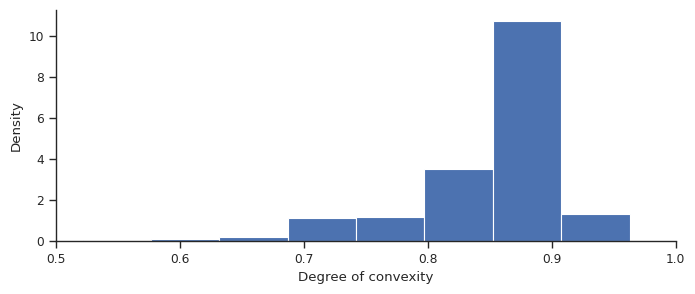

In [17]:
plt.figure(figsize=(8, 3))
plt.hist(d_c, bins=10, density=True)
plt.xlabel('Degree of convexity')
plt.ylabel('Density')
sns.despine()
plt.xlim(0.5, 1)
plt.show()

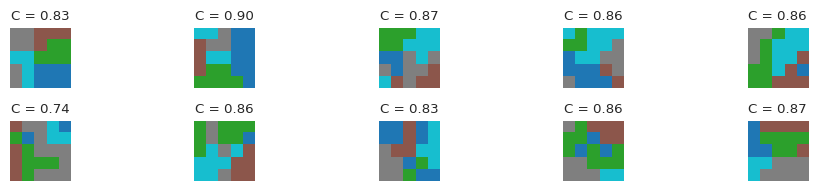

In [18]:
# plot 2x10 random languages from L
fig, ax = plt.subplots(2, 5, figsize=(10, 2))

for i, l in enumerate(np.random.choice(range(20000), 10, replace=False)):
    ax[i//5, i%5].imshow(L[l], cmap='tab10', interpolation='none')
    ax[i//5, i%5].axis('off')
    # title should be degree of convexity
    ax[i//5, i%5].set_title(f"C = {degree_of_convexity(np.expand_dims(L[l], 0))[0]:.2f}")

plt.tight_layout()
# save the plot as png
plt.savefig('figures/random_lexicons.png')
plt.show()

In [46]:
a = Experiment(alpha=1, 
               shape=shape, 
               n=len(L), 
               n_iter=n_iter, 
               n_rounds=n_rounds,
               prior=np.ones(shape[0] * shape[1]) / (shape[0] * shape[1]), 
               convex=True, # convexity bias
               treshold=0, # no treshold
               beta=0.1, # strong convexity bias
               Lexicons=L,
               simple=False) # simplicity bias)
a.run()
mi_convex = calculate_normalized_mutual_info(a, n_iter, n_rounds)

In [47]:
b = Experiment(alpha=1, 
               shape=shape, 
               n=len(L), 
               n_iter=n_iter, 
               n_rounds=n_rounds,
               prior= np.ones(shape[0] * shape[1]) / (shape[0] * shape[1]), #prior_m_matrix.ravel()
               convex=False, # no convexity bias
               treshold=0, # no treshold
               beta=1, # no skew towards convex lexicons
               Lexicons=L,
               simple=False) # simplicity bias)
b.run()
mi_nconvex = calculate_normalized_mutual_info(b, n_iter, n_rounds)

In [48]:
c = Experiment(alpha=1,
                shape=shape, 
                n=len(L), 
                n_iter=n_iter, 
                n_rounds=n_rounds,
                prior= np.ones(shape[0] * shape[1]) / (shape[0] * shape[1]), 
                convex=False, # convexity bias
                treshold=0, # no treshold
                beta=0.1, # simplicity bias
                Lexicons=L,
                simple=True) # simplicity bias)
c.run()
mi_simple = calculate_normalized_mutual_info(c, n_iter, n_rounds)

In [49]:
# generate 1000 random matrices and compute the baseline
baseline = []

# for i in range(1000):
#     baseline.append(normalized_mutual_info_score(np.random.randint(0, N, shape).ravel(),   
#                                                  np.random.randint(0, N, shape).ravel()))

# sample randomly from LS and compute the baseline
for i in range(1000):
    baseline.append(normalized_mutual_info_score(L[np.random.choice(range(len(L)))].ravel(),   
                                                 L[np.random.choice(range(len(L)))].ravel()))

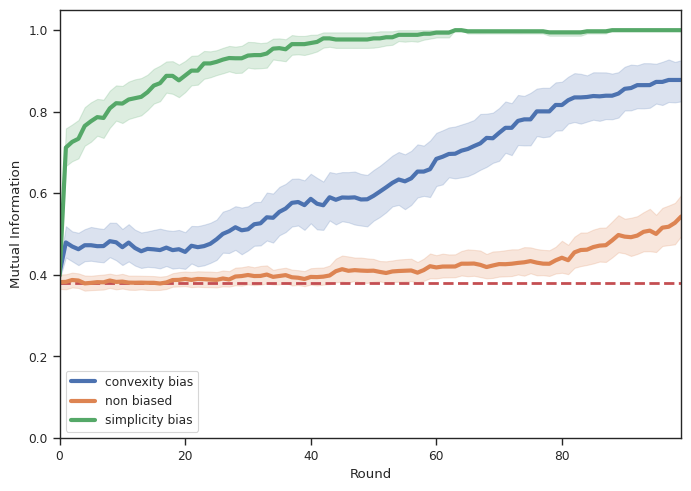

In [50]:
fig, ax = plt.subplots(figsize=(7, 5))
# for mi in mis:
#     plt.plot(mi, color = 'blue', alpha=0.05, linewidth=3)
# plot mean mutual information
# plot the baseline
plt.axhline(y=np.mean(baseline), 
            color='r', 
            linestyle='--', 
            linewidth=2, 
            alpha=1)
sns.lineplot(x="variable", 
             y="value", 
             data=mi_convex,
             linewidth=3,
             label='convexity bias')
sns.lineplot(x="variable", 
             y="value", 
             data=mi_nconvex,
             linewidth=3,
             label='non biased')
sns.lineplot(x="variable",
             y="value",
             data=mi_simple,
             linewidth=3,
             label='simplicity bias')
plt.ylim(0, 1.05)
plt.xlabel('Round')
plt.ylabel('Mutual Information')
plt.tight_layout()
plt.legend()
# log space y 
# ax.set_yscale('log')
# ax.grid(which='major', color='#DDDDDD', linewidth=0.8)
# ax.grid(which='minor', color='#EEEEEE', linestyle=':', linewidth=0.5)
# ax.minorticks_on()
plt.margins(x=0)
plt.show()

In [51]:
# for every variable in mi_nconvex, add a new column with range(n_iter) and then melt the dataframe
mi_nconvex['group'] = list(range(n_iter)) * n_rounds
mi_convex['group'] = list(range(n_iter)) * n_rounds
mi_simple['group'] = list(range(n_iter)) * n_rounds

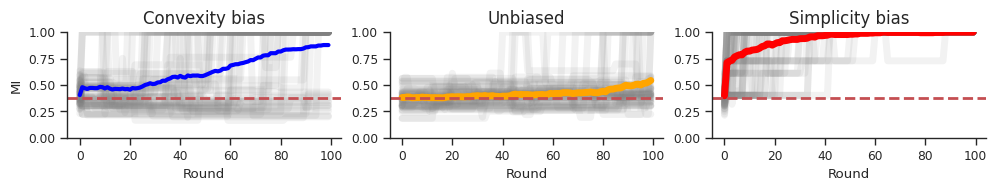

In [52]:
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(10, 2))
# remove borders on the top and right in all subplots
ax1.spines['top'].set_visible(False)
ax1.spines['right'].set_visible(False)
ax2.spines['top'].set_visible(False)
ax2.spines['right'].set_visible(False)
ax3.spines['top'].set_visible(False)
ax3.spines['right'].set_visible(False)

# Convex subplot
ax1.set_title('Convexity bias', fontsize=12)
for group in mi_convex.group.unique():
    if group % 2 == 0:
        ax1.plot(range(n_rounds), mi_convex[mi_convex.group == group].value, 
                 color='grey', alpha=0.1, linewidth=5)

# plot mean mutual information by grouping by variable
ax1.plot(range(n_rounds), mi_convex.groupby('variable').value.mean(), color='blue', linewidth=3)

# Non-convex subplot
ax2.set_title('Unbiased',  fontsize=12)
for group in mi_nconvex.group.unique():
    if group % 2 == 0:
        ax2.plot(range(n_rounds), mi_nconvex[mi_nconvex.group == group].value, 
                 color='grey', alpha=0.1, linewidth=5)

# plot mean mutual information by grouping by variable
ax2.plot(range(n_rounds), mi_nconvex.groupby('variable').value.mean(), color='orange', linewidth=5)

# Simplicity subplot
ax3.set_title('Simplicity bias', fontsize=12)
for group in mi_simple.group.unique():
    if group % 2 == 0:
        ax3.plot(range(n_rounds), mi_simple[mi_simple.group == group].value, 
                 color='grey', alpha=0.1, linewidth=5)

# plot mean mutual information by grouping by variable
ax3.plot(range(n_rounds), mi_simple.groupby('variable').value.mean(), color='red', linewidth=5)

# Random baseline
ax1.axhline(y=np.mean(baseline), color='r', linestyle='--', linewidth=2, alpha=1)
ax2.axhline(y=np.mean(baseline), color='r', linestyle='--', linewidth=2, alpha=1)
ax3.axhline(y=np.mean(baseline), color='r', linestyle='--', linewidth=2, alpha=1)

ax1.set_xlabel('Round')
ax1.set_ylabel('MI')
# ax2.set_ylabel('MI')
# ax3.set_ylabel('MI')
ax2.set_xlabel('Round')
ax3.set_xlabel('Round')

# set ylim to be 0-1 for all subplots
ax1.set_ylim(0, 1)
ax2.set_ylim(0, 1)
ax3.set_ylim(0, 1)

plt.tight_layout()
plt.savefig('figures/study_2/one_run.pdf', dpi=300, bbox_inches='tight')
plt.show()

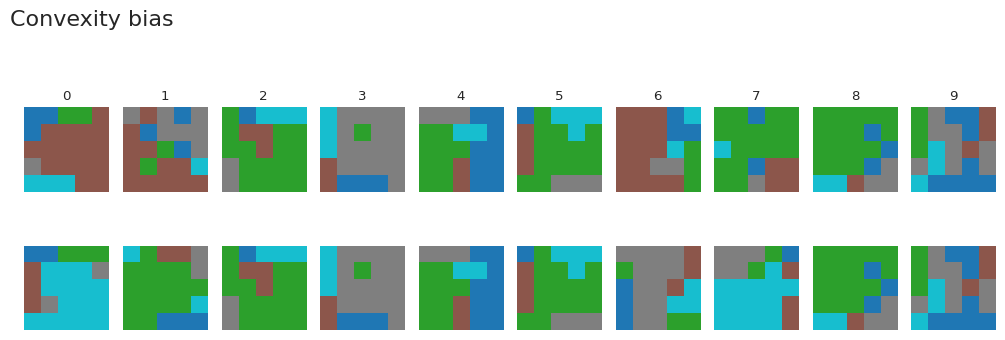

In [43]:
plot_last_lexicons(a, n_iter, pos=-1, title='Convexity bias')

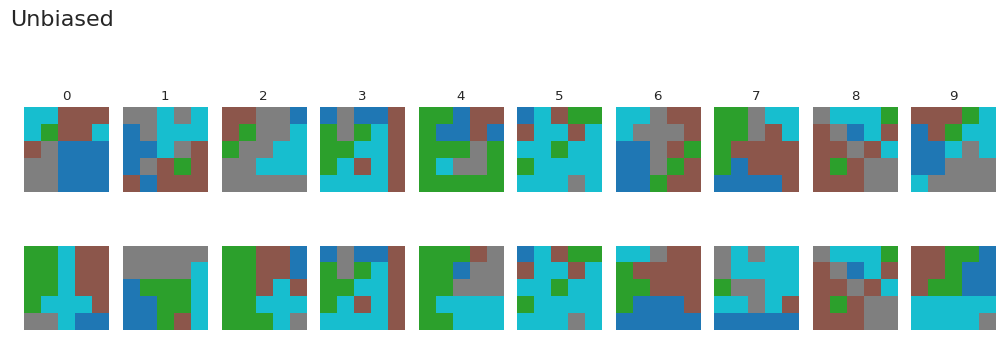

In [44]:
plot_last_lexicons(b, n_iter, pos=-1, title='Unbiased')

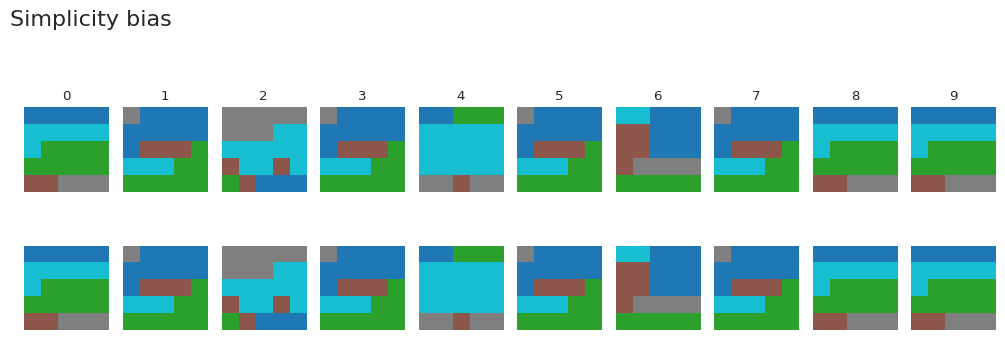

In [45]:
plot_last_lexicons(c, n_iter, pos=-1, title='Simplicity bias')

## Running with multiple N

In [34]:
SHAPE = (5, 5)

coords = np.array(np.meshgrid(np.arange(SHAPE[0]), np.arange(SHAPE[1]))).T.reshape(-1, 2)
coords = [tuple(i) for i in coords]


coords_dict = defaultdict(list)
for i, coord in enumerate(coords):
    coords_dict[tuple(coord)] = tuple(coord)

In [35]:
def generate_coords(shape):
    coords = np.array(np.meshgrid(np.arange(shape[0]), 
                                  np.arange(shape[1]))).T.reshape(-1, 2)
    coords = [tuple(i) for i in coords]

    # dictionary mapping coords to themselves
    coords_dict = {coord: coord for coord in coords}
    
    return coords, coords_dict

In [38]:
def efficiency_simplicity_analysis(n, shape, N_min, N_max, beta):

    n_iter = 100
    n_rounds = 100

    LS_ = []
    convex_lexicons = []
    non_convex_lexicons = []
    simplicity_lexicons = []

    # mi_convex = []
    # mi_nconvex = []
    # mi_simple = []

    coords, coords_dict = generate_coords(shape)

    for N in trange(N_min, N_max):

        LS = generate_lexicons(N, shape, n)

        # prior = np.ones(shape[1] * shape[0]) / shape[1] * shape[0]
        
        a = Experiment(alpha=1, 
               shape=shape, 
               n=len(LS), 
               n_iter=n_iter, 
               n_rounds=n_rounds,
               prior= np.ones(shape[1] * shape[0]) / shape[1] * shape[0], 
               convex=True,
               treshold=0,
               beta=beta,
               Lexicons=LS,
               simple=False)
        a.run()

        convex_lexicons.append([a.logs[i]['a1'][-1] for i in range(n_iter)])
        convex_lexicons.append([a.logs[i]['a2'][-1] for i in range(n_iter)])

        # calculate normalized mutual information for last round using list comprehension
        mi_convex = [normalized_mutual_info_score(a.logs[i]['a1'][-1].ravel(), 
                                                       a.logs[i]['a2'][-1].ravel()) for i in range(n_iter)]

        b = Experiment(alpha=1,
                shape=shape,
                n=len(LS),
                n_iter=n_iter,
                n_rounds=n_rounds,
                prior= np.ones(shape[1] * shape[0]) / shape[1] * shape[0],
                convex=False,
                treshold=0,
                beta=beta,
                Lexicons=LS,
                simple=False)
        b.run()
        
        non_convex_lexicons.append([b.logs[i]['a1'][-1] for i in range(n_iter)])
        non_convex_lexicons.append([b.logs[i]['a2'][-1] for i in range(n_iter)])

        # calculate normalized mutual information for last round using list comprehension
        mi_nconvex = [normalized_mutual_info_score(b.logs[i]['a1'][-1].ravel(),
                                                        b.logs[i]['a2'][-1].ravel()) for i in range(n_iter)]

        c = Experiment(alpha=1,
                    shape=shape,
                    n=len(LS),
                    n_iter=n_iter,
                    n_rounds=n_rounds,
                    prior= np.ones(shape[1] * shape[0]) / shape[1] * shape[0],
                    convex=False,
                    treshold=0,
                    beta=beta,
                    Lexicons=LS,
                    simple=True)
        c.run()

        simplicity_lexicons.append([c.logs[i]['a1'][-1] for i in range(n_iter)])
        simplicity_lexicons.append([c.logs[i]['a2'][-1] for i in range(n_iter)])

        # calculate normalized mutual information for last round using list comprehension
        mi_simple = [normalized_mutual_info_score(c.logs[i]['a1'][-1].ravel(),
                                                      c.logs[i]['a2'][-1].ravel()) for i in range(n_iter)]

        LS_.append(LS)

    # # flatten the list of lists lexicons
    # lexicons_convex = [item for sublist in lexicons_convex for item in sublist]
    # lexicons_nconvex = [item for sublist in lexicons_nconvex for item in sublist]
    # flatten the list of lists lexicons
    convex_lexicons = [item for sublist in convex_lexicons for item in sublist]
    non_convex_lexicons = [item for sublist in non_convex_lexicons for item in sublist]
    simplicity_lexicons = [item for sublist in simplicity_lexicons for item in sublist]

    # flatten LS_
    LS_ = [item for sublist in LS_ for item in sublist]
    
    return convex_lexicons, non_convex_lexicons, simplicity_lexicons, LS_, coords, coords_dict, mi_convex, mi_nconvex, mi_simple
        

In [39]:
lexicons_convex, lexicons_nconvex, lexicons_simple, LS_, coords, coords_dict, mi_convex, mi_nconvex, mi_simple  = efficiency_simplicity_analysis(20000, 
                                                                                                                                                 SHAPE, 
                                                                                                                                                 3, 10, 
                                                                                                                                                 beta=0.1)

  0%|          | 0/7 [00:00<?, ?it/s]

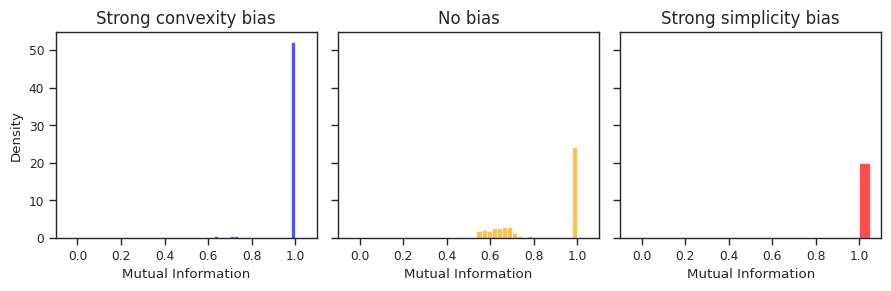

In [40]:
# plot mutual information distribution for all models 3 subplots
fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(9, 3), sharey=True)

# Convex subplot
ax1.hist(mi_convex, bins=20, density=True, color='blue', alpha=0.7)
ax1.set_xlabel('Mutual Information')
ax1.set_ylabel('Density')
ax1.set_title('Strong convexity bias', fontsize=12)

# Non-convex subplot
ax2.hist(mi_nconvex, bins=20, density=True, color='orange', alpha=0.7)
ax2.set_xlabel('Mutual Information')
ax2.set_title('No bias', fontsize=12)

# Simplicity subplot
ax3.hist(mi_simple, bins=20, density=True, color='red', alpha=0.7)
ax3.set_xlabel('Mutual Information')
ax3.set_title('Strong simplicity bias', fontsize=12)

# xlim to be 0-1
ax1.set_xlim(-0.1, 1.1)
ax2.set_xlim(-0.1, 1.1)
ax3.set_xlim(-0.1, 1.1)

plt.tight_layout()
plt.show()

In [41]:
# print mean and standard deviation of mutual information for each model
print(f"Mean MI for convexity biased agents: {np.mean(mi_convex):.3f} (std: {np.std(mi_convex):.3f})")
print(f"Mean MI for non biased agents: {np.mean(mi_nconvex):.3f} (std: {np.std(mi_nconvex):.3f})")
print(f"Mean MI for simplicity biased agents: {np.mean(mi_simple):.3f} (std: {np.std(mi_simple):.3f})")


Mean MI for convexity biased agents: 0.991 (std: 0.053)
Mean MI for non biased agents: 0.841 (std: 0.183)
Mean MI for simplicity biased agents: 1.000 (std: 0.000)


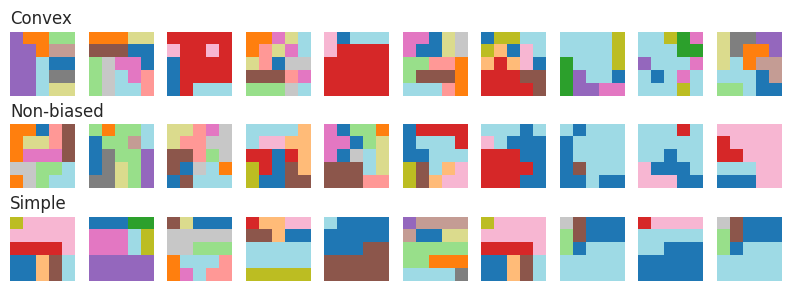

In [42]:
fig, ax = plt.subplots(3, 10, figsize=(8, 3))

for i in range(10):
    ax[0, i].imshow(lexicons_convex[np.random.choice(range(len(lexicons_convex)))], cmap='tab20', interpolation='none')
    ax[1, i].imshow(lexicons_nconvex[np.random.choice(range(len(lexicons_nconvex)))], cmap='tab20', interpolation='none')
    ax[2, i].imshow(lexicons_simple[np.random.choice(range(len(lexicons_simple)))], cmap='tab20', interpolation='none')
    
    ax[0, i].axis('off')
    ax[1, i].axis('off')
    ax[2, i].axis('off')

ax[0, 0].set_title('Convex', loc='left', fontsize=12)
ax[1, 0].set_title('Non-biased', loc='left', fontsize=12)
ax[2, 0].set_title('Simple', loc='left', fontsize=12)

plt.tight_layout()
# save to pdf
plt.savefig('figures/study_2/lexicons.png')
plt.show()

In [43]:
# compute simplicity and informativeness for all types of models
simplicity_convex = [compression(lexicon) for lexicon in lexicons_convex]
informativeness_convex = [informativeness(lexicon, p_m=None, cielab_dict=coords_dict) for lexicon in lexicons_convex]

simplicity_nconvex = [compression(lexicon) for lexicon in lexicons_nconvex] 
informativeness_nconvex = [informativeness(lexicon, p_m=None, cielab_dict=coords_dict) for lexicon in lexicons_nconvex]

simplicity_simple = [compression(lexicon) for lexicon in lexicons_simple]
informativeness_simple = [informativeness(lexicon, p_m=None, cielab_dict=coords_dict) for lexicon in lexicons_simple]

# compute simplicity for the prior
simplicity_prior = [compression(l) for l in LS_]

informativeness_prior = [informativeness(l, p_m=None, cielab_dict=coords_dict) for l in LS_]

In [44]:
pareto_front_indices = non_dominated_front(simplicity_prior, informativeness_prior) 
pareto_front_points = [(simplicity_prior[i], informativeness_prior[i]) for i in pareto_front_indices]

In [45]:
# find duplicates in either x or y and remove them
pareto_front_points = list(set(pareto_front_points))
x_pareto, y_pareto = zip(*pareto_front_points)

# create a smooth line over x_pareto and y_pareto using lowess
lowess = sm.nonparametric.lowess
smoothed = lowess(y_pareto, x_pareto)

In [46]:
LS_filtered = [lexicon for lexicon, informativeness in zip(LS_, informativeness_prior) if informativeness > 0]

In [47]:
len(LS_filtered)

0

In [48]:
# # plot ls filtered
# fig, ax = plt.subplots(1, 1)

# for i in range(1):
#     ax[i].imshow(LS_filtered[i], cmap='tab20', interpolation='none')
#     ax[i].axis('off')

# plt.tight_layout()
# plt.show()

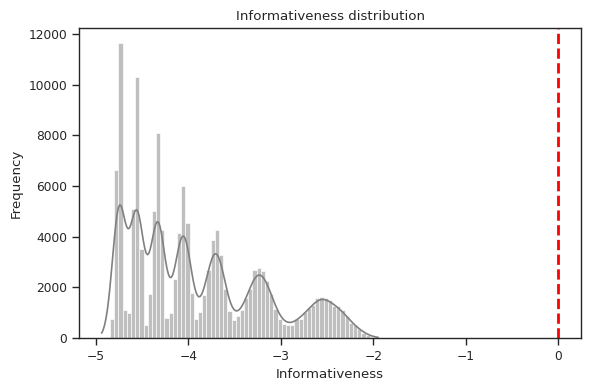

In [49]:
# plot distribution of informativeness from prior
fig, ax = plt.subplots(figsize=(6, 4))
sns.histplot(informativeness_prior, kde=True, color='grey')
# add a red line at 0
plt.axvline(x=0, color='red', linestyle='--', linewidth=2)
plt.xlabel('Informativeness')
plt.ylabel('Frequency')
plt.title('Informativeness distribution')
plt.tight_layout()
plt.show()

In [50]:
# compute the distance between the pareto front and the points
distances_convex = euclidean_distances([(simplicity, informativeness) for simplicity, informativeness in zip(simplicity_convex, informativeness_convex)], 
                                      smoothed)

distances_nconvex = euclidean_distances([(simplicity, informativeness) for simplicity, informativeness in zip(simplicity_nconvex, informativeness_nconvex)],
                                        smoothed)

distances_simple = euclidean_distances([(simplicity, informativeness) for simplicity, informativeness in zip(simplicity_simple, informativeness_simple)],
                                        smoothed)

# convert to min distance for each point
distances_convex = np.min(distances_convex, axis=1)
distances_nconvex = np.min(distances_nconvex, axis=1)
distances_simple = np.min(distances_simple, axis=1)

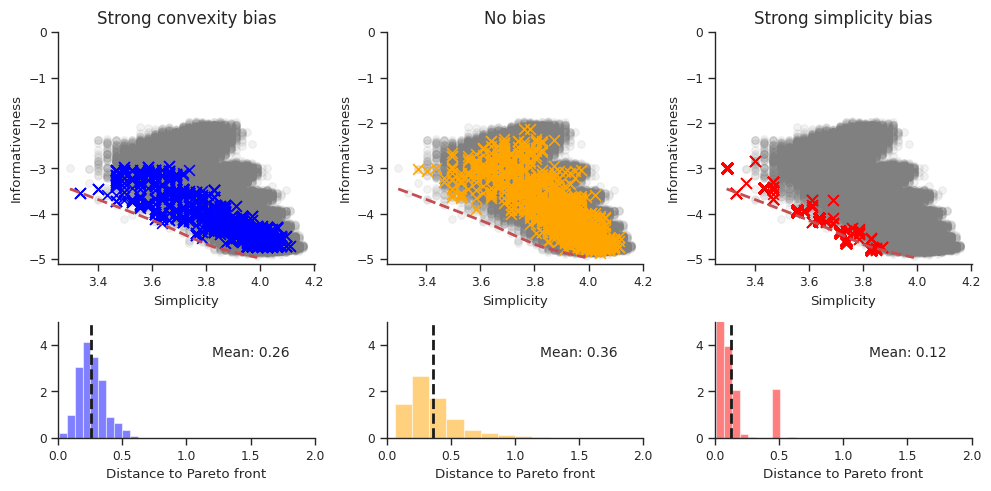

In [51]:
fig, axs = plt.subplots(2, 3, figsize=(10, 5), squeeze=True, 
                       gridspec_kw = {'height_ratios':[2, 1]})

# Plot 1: Simplicity-Informativeness Biases
sc1 = axs[0, 0].scatter(simplicity_prior, informativeness_prior, alpha=0.1, color='grey', s=30)
sc1.set_rasterized(True)
axs[0, 0].scatter(simplicity_convex, informativeness_convex, alpha=1, marker='x', color='blue', s=60)
axs[0, 0].set_xlabel('Simplicity')
axs[0, 0].set_ylabel('Informativeness')
axs[0, 0].set_title('Strong convexity bias', fontsize=12)
axs[0, 0].plot(smoothed[:, 0], smoothed[:, 1], 'r--', alpha=1, linewidth=2)
axs[0, 0].set_ylim(None, 0)

sc2 = axs[0, 1].scatter(simplicity_prior, informativeness_prior, alpha=0.1, color='grey', s=30)
sc2.set_rasterized(True)
axs[0, 1].scatter(simplicity_nconvex, informativeness_nconvex, alpha=1, marker='x', color='orange', s=60)
axs[0, 1].set_xlabel('Simplicity')
axs[0, 1].set_ylabel('Informativeness')
axs[0, 1].set_title('No bias', fontsize=12)
axs[0, 1].plot(smoothed[:, 0], smoothed[:, 1], 'r--', alpha=1, linewidth=2)
axs[0, 1].set_ylim(None, 0)

sc3 = axs[0, 2].scatter(simplicity_prior, informativeness_prior, alpha=0.1, color='grey', s=30)
sc3.set_rasterized(True)
axs[0, 2].scatter(simplicity_simple, informativeness_simple, alpha=1, marker='x', color='red', s=60)
# rasterize the scatter plot
axs[0, 2].set_rasterization_zorder(1)
axs[0, 2].set_xlabel('Simplicity')
axs[0, 2].set_ylabel('Informativeness')
axs[0, 2].set_title('Strong simplicity bias', fontsize=12)
axs[0, 2].plot(smoothed[:, 0], smoothed[:, 1], 'r--', alpha=1, linewidth=2)
axs[0, 2].set_ylim(None, 0)

# Plot 2: Distance to Pareto Front
axs[1, 0].hist(distances_convex.ravel(), bins=10, color='blue', density=True, alpha=0.5)
axs[1, 0].axvline(np.median(distances_convex.mean()), color='k', linestyle='dashed', linewidth=2)
axs[1, 0].set_xlabel('Distance to Pareto front')
# write the mean value in the top right corner of the plot
axs[1, 0].text(1.5, 3.5, f"Mean: {np.mean(distances_convex.mean()):.2f}", fontsize=10, ha='center')
axs[1, 0].set_xlim(0, 2)
axs[1, 0].set_ylim(0, 5)

axs[1, 1].hist(distances_nconvex.ravel(), bins=10, color='orange', density=True, alpha=0.5)
axs[1, 1].axvline(np.median(distances_nconvex.mean()), color='k', linestyle='dashed', linewidth=2)
axs[1, 1].set_xlabel('Distance to Pareto front')
axs[1, 1].text(1.5, 3.5, f"Mean: {np.mean(distances_nconvex.mean()):.2f}", fontsize=10, ha='center')
axs[1, 1].set_xlim(0, 2)
axs[1, 1].set_ylim(0, 5)

axs[1, 2].hist(distances_simple.ravel(), bins=10, color='red', density=True, alpha=0.5)
axs[1, 2].axvline(np.median(distances_simple.mean()), color='k', linestyle='dashed', linewidth=2)
axs[1, 2].set_xlabel('Distance to Pareto front')
axs[1, 2].text(1.5, 3.5, f"Mean: {np.mean(distances_simple.mean()):.2f}", fontsize=10, ha='center')
axs[1, 2].set_xlim(0, 2)
axs[1, 2].set_ylim(0, 5)

plt.tight_layout()
sns.despine()
# save the figure
plt.savefig('figures/study_2/simplicity_informativeness_bias.png', dpi=300)
plt.show()

In [61]:
# print mean informativeness and simplicity for each model (add sd as well)
print(f"Mean simplicity for convex model: {np.mean(simplicity_convex):.3f} (SD: {np.std(simplicity_convex):.3f})")

print(f"Mean simplicity for non-convex model: {np.mean(simplicity_nconvex):.3f} (SD: {np.std(simplicity_nconvex):.3f})")

print(f"Mean simplicity for simplicity model: {np.mean(simplicity_simple):.3f} (SD: {np.std(simplicity_simple):.3f})")

print(f"Mean informativeness for convex model: {np.mean(informativeness_convex):.3f} (SD: {np.std(informativeness_convex):.3f})")

print(f"Mean informativeness for non-convex model: {np.mean(informativeness_nconvex):.3f} (SD: {np.std(informativeness_nconvex):.3f})")

print(f"Mean informativeness for simplicity model: {np.mean(informativeness_simple):.3f} (SD: {np.std(informativeness_simple):.3f})")

Mean simplicity for convex model: 3.835 (SD: 0.168)
Mean simplicity for non-convex model: 3.884 (SD: 0.139)
Mean simplicity for simplicity model: 3.604 (SD: 0.172)
Mean informativeness for convex model: -4.086 (SD: 0.496)
Mean informativeness for non-convex model: -3.972 (SD: 0.634)
Mean informativeness for simplicity model: -4.043 (SD: 0.588)


In [62]:
# perform t-test for informativeness for convex and simple
from scipy.stats import ttest_ind
ttest_ind(informativeness_convex, informativeness_simple)

TtestResult(statistic=-2.102097983438575, pvalue=0.03563385384606257, df=2798.0)

In [63]:
# print mean distance to the pareto front
print(f"Mean distance to pareto front for convex: {np.mean(distances_convex)}")
print(f"Mean distance to pareto front for non convex: {np.mean(distances_nconvex)}")
print(f"Mean distance to pareto front for simple: {np.mean(distances_simple)}")

Mean distance to pareto front for convex: 0.2587156101651723
Mean distance to pareto front for non convex: 0.3589081956813786
Mean distance to pareto front for simple: 0.12339689340859844


In [65]:
# determine whether the mean distance to the pareto front is significantly different in all models
# using a t-test
from scipy.stats import ttest_ind

t, p = ttest_ind(distances_convex, distances_nconvex)
print(f"t: {round(t, 5)}, p: {round(p, 10)}")

t, p = ttest_ind(distances_convex, distances_simple)
print(f"t: {round(t, 5)}, p: {round(p, 10)}")

t, p = ttest_ind(distances_nconvex, distances_simple)
print(f"t: {round(t, 5)}, p: {round(p, 10)}")


t: -16.55241, p: 0.0
t: 29.26265, p: 0.0
t: 35.75266, p: 0.0
